# Modelo 1 - XGBoost

En este notebook se presenta el primer modelo de predicción de ciberataques, utilizando el modelo [XGboost](https://xgboost.readthedocs.io/en/stable/) y la base de datos previamente tratada. La construcción se dividió en las siguientes partes:

1. Cargado de la base de datos
2. Entrenamiento con el modelo predeterminado de la librería `xgboost`
3. Entrenamiento del modelo con variables más relevantes (Feature Importance)
4. Búsqueda de hiperparámetros a partir de GridSearchCV
4. Conclusiones

# 1. Cargado de Base

Para este ejercicio se utilizó la base de **CIC-DDoS2019**, que se carga a continuación junto con las demas librerías que se utilizaron en el ejercicio:

In [ ]:
# Montado de drive para realizar el análisis
from google.colab import drive
drive.mount('/content/drive')
#Librerías Utilizadas
import pandas as pd # Manipulación de datos
pd.options.display.float_format = '{:.1f}'.format # Adecuar formato de salidas de tablas a 1 posición decimal
import seaborn as sns # Creación de gráficas
import matplotlib.pyplot as plt # Formato de gráficas
import numpy as np
# Herramientas de análisis de modelos
from sklearn.model_selection import train_test_split, GridSearchCV # Creación set entrenamiento - validación
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score # Medición de precisión
from sklearn.preprocessing import LabelEncoder
# Librerías modelo XGbost
from xgboost import XGBClassifier # Modelo a entrenar
from xgboost import plot_importance # Gráfica para ver pesos de las variables

Mounted at /content/drive


Con estas librerías se realizó el cargue de la información, que corresponde a 431371 filas y 39 columnas y donde no hay valores nulos:

In [ ]:
df_CIC2019_corr = pd.read_parquet("/content/drive/MyDrive/Tesis - Machine Learning/Tesis - Machine Learning/E - Modelo predicción/Base/CICIDS2019_2.parquet")

In [ ]:
df_CIC2019_corr.head(5)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Flow Bytes/s,Flow Packets/s,Fwd PSH Flags,Fwd Header Length,...,Fwd Seg Size Min,Label,Packet Length Mean,Fwd Packet Length Mean,Active Mean,Fwd IAT Mean,Idle Mean,Bwd IAT Mean,Bwd Packet Length Mean,Flow IAT Mean
0,17,48,4,0,1616.0,0.0,33666666.7,83333.3,0,80,...,20,DrDoS_NTP,411.2,404.0,0.0,16.0,0.0,0.0,0.0,16.0
1,17,557,112,0,49280.0,0.0,88473967.7,201077.2,0,0,...,0,DrDoS_NTP,440.0,440.0,0.0,5.0,0.0,0.0,0.0,5.0
2,6,323228,14,12,1736.0,526.0,6998.2,80.4,0,304,...,20,Benign,83.8,124.0,0.0,24863.7,0.0,15038.7,43.8,12929.1
3,17,46917,2,2,86.0,118.0,4348.1,85.3,0,40,...,20,Benign,49.4,43.0,0.0,3.0,0.0,2.0,59.0,15639.0
4,17,254,58,0,25520.0,0.0,100472440.9,228346.5,0,-58,...,-1,DrDoS_NTP,440.0,440.0,0.0,4.5,0.0,0.0,0.0,4.5


In [ ]:
# Revisión de Valores Nulos
df_CIC2019_corr.isna().sum().sort_values(ascending=False)

Protocol                    0
Flow Duration               0
Total Fwd Packets           0
Total Backward Packets      0
Fwd Packets Length Total    0
Bwd Packets Length Total    0
Flow Bytes/s                0
Flow Packets/s              0
Fwd PSH Flags               0
Fwd Header Length           0
Bwd Header Length           0
Fwd Packets/s               0
Bwd Packets/s               0
SYN Flag Count              0
RST Flag Count              0
ACK Flag Count              0
URG Flag Count              0
CWE Flag Count              0
Down/Up Ratio               0
Avg Packet Size             0
Avg Fwd Segment Size        0
Avg Bwd Segment Size        0
Subflow Fwd Packets         0
Subflow Fwd Bytes           0
Subflow Bwd Packets         0
Subflow Bwd Bytes           0
Init Fwd Win Bytes          0
Init Bwd Win Bytes          0
Fwd Act Data Packets        0
Fwd Seg Size Min            0
Label                       0
Packet Length Mean          0
Fwd Packet Length Mean      0
Active Mea

# 2. Entrenamiento con modelo predeterminado

Como punto de referencia, se crearon los dataset de entrenamiento y validación para esta base, con una proporción de 80-20:


In [ ]:
# Variables a entrenar
X1 = df_CIC2019_corr.drop(columns="Label")
# Variable objetivo - sospechosos
le = LabelEncoder()
#Conversión de texto a numero (XGBOOST no funciona con variables tipo STRING)
encoded = le.fit_transform(df_CIC2019_corr["Label"])
y = encoded
# División entrenamiento - rest con ratio de 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

En ellos se entrena el modelo usando la GPU disponible en Google Colab. No obstante, para poder usarla en el modelo y aumentar su velocidad es necesario definir los siguientes 2 parámetros como:

```
tree_method = "hist"
devide = "cuda
```

Con esto implementado, se entrenó el modelo y se identificó su tiempo de ejecución:

In [ ]:
%%time
clf = XGBClassifier(tree_method = "hist", device = "cuda").fit(X_train, y_train)

CPU times: user 9.76 s, sys: 422 ms, total: 10.2 s
Wall time: 9.67 s


Luego se calcularon las principales métricas de desempeño:

- Precisión
- Exactitud
- Exhaustividad (recall)


In [ ]:
y_model = clf.predict(X_test)
#Precisión
acc = accuracy_score(y_test,y_model)
print(f"Precisión: {acc}")
#Recall
rec = recall_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"Recall: {rec}")
# F1 - Score
f1 = f1_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"F1 score: {f1}")

Precisión: 0.9827991886409736


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:56:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Recall: 0.9827991886409736
F1 score: 0.9822050608897209


Considerando estos resultados se gráfica a partir de un mapa de calor la matriz de confusión para los 11 tipos de ataques y el caso benigno:

In [ ]:
# Clases consideradas en el modelo
le.classes_ # Relación entre el número real y el STRING

array(['Benign', 'DrDoS_DNS', 'DrDoS_NTP', 'DrDoS_SNMP', 'LDAP', 'MSSQL',
       'NetBIOS', 'Portmap', 'Syn', 'TFTP', 'UDP', 'WebDDoS'],
      dtype=object)

Como se evidencia en la gráfica, hay un desbalance de número de registros por caso, ya que por ejemplo en el caso de DrDoS_NTP hay más de 24 mil registros mientras que para DrDoS_DNS estos son menos de 1000. Por ello, para analizar de forma clara la efectividad de predicción para cada tipo de caso se normalizó la matriz de confusión y se volvió a graficar:

<Axes: >

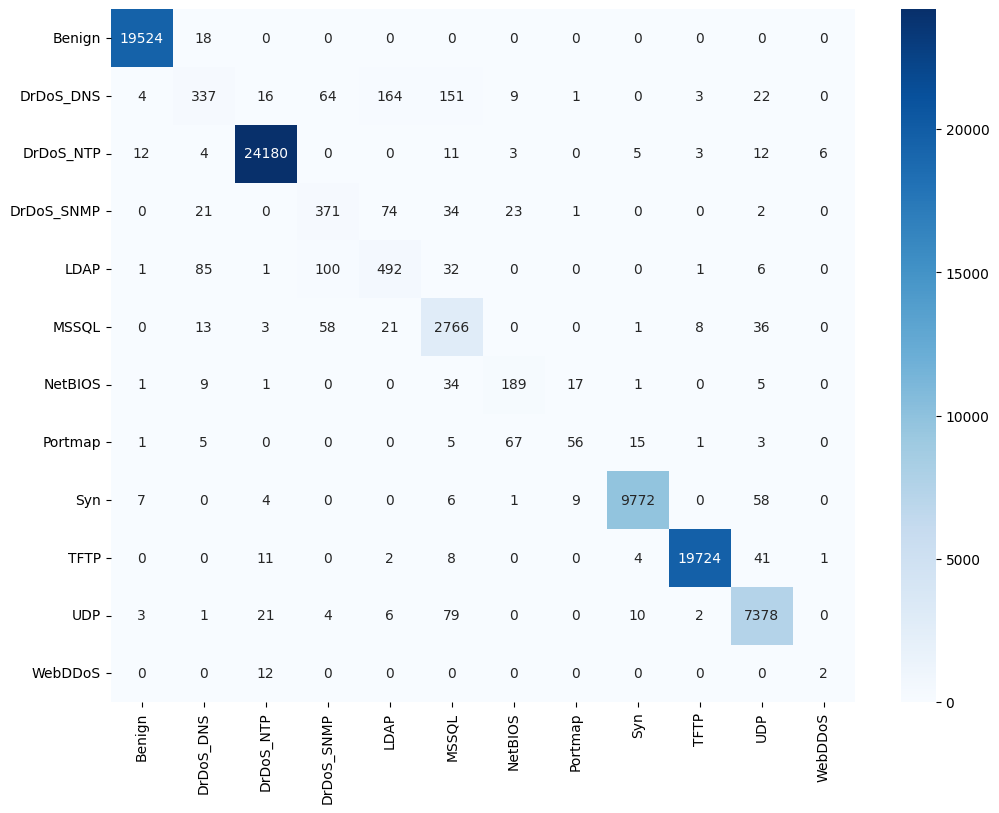

In [ ]:
# Gráfica de resultados
plt.figure(figsize=(12,9))
sns.heatmap(confusion_matrix(y_test, y_model),annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_,yticklabels=le.classes_)

Con los resultados normalizados se identifica que predice casi en un 100% los ataques de DrDos_NTP, MSSQL, Syn, TFTP y UDP mientras que para los demás este valor se reduce. El más crítico corresponde al ataque WebDDoS ya que sólo fueron predichos con exactitud 14% de los registros asociados con este ataque:

<Axes: >

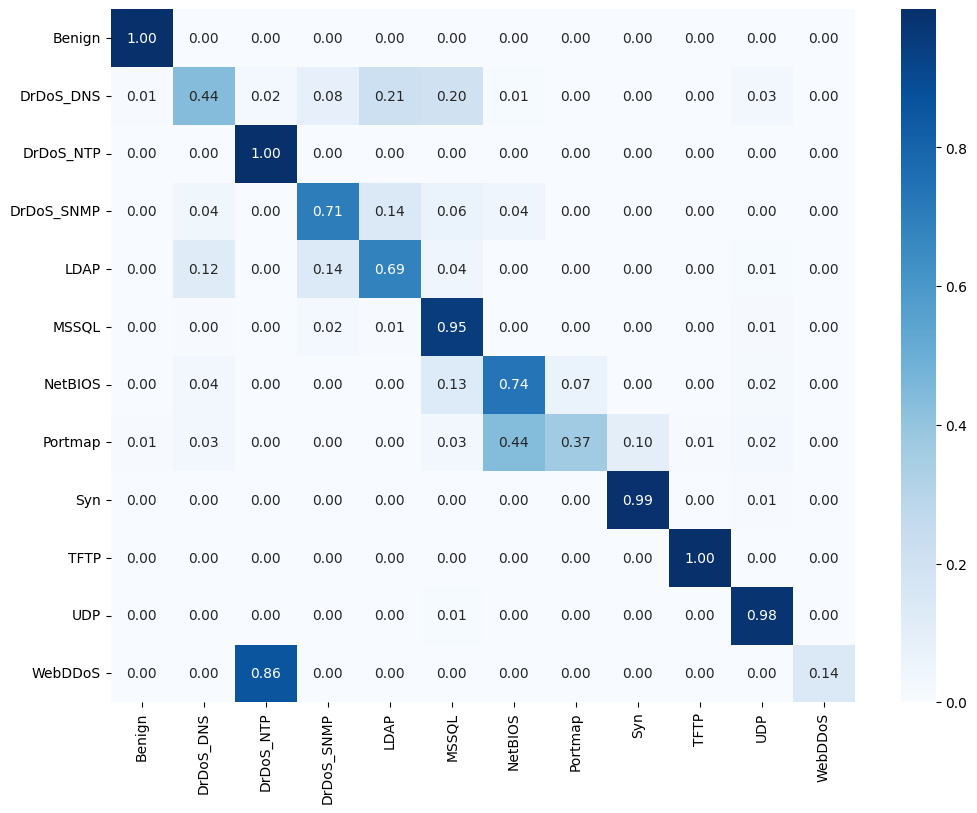

In [ ]:
# Matriz Normalizada
plt.figure(figsize=(12,9))
cm=confusion_matrix(y_test, y_model)
# Proceso de normalización
cm_normalized= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized,annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_,yticklabels=le.classes_)

Por último se graficó la importancia de la variables en el resultado final del modelo utilizando la función `plot_importance` de la librería XGBoost:

<Figure size 1500x900 with 0 Axes>

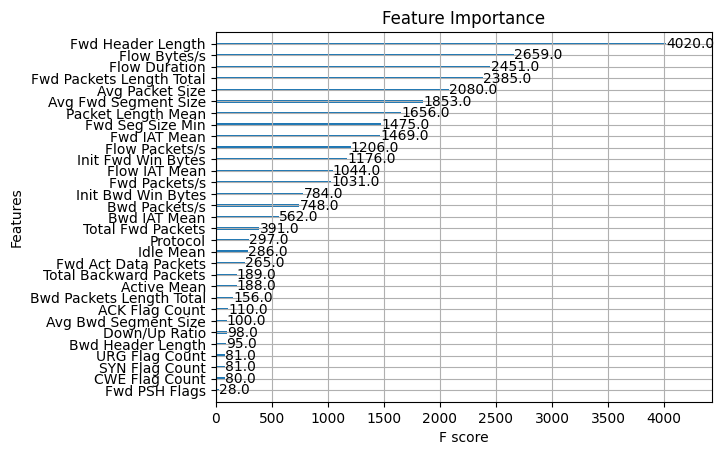

In [ ]:
# Graficar la importancia de las variables
plt.figure(figsize=(15, 9))
plot_importance(clf, importance_type='weight')
plt.title('Feature Importance')
plt.show()


# 3. Entrenamiento modelo con variables más relevantes (Feature Importance)

Con motivo de encontrar un modelo con un número menor de variables se optó por tomar las 15 columnas con mayor importancia, sin disminuir importantemente la precisión y demás métricas.

Se utilizó la opción `get_booster().get_score(importance_type='weight')` para guardar en un diccionario los valores de todas las variables, que luego se pasaron a un DataFrame para mostrar las 15 primeras:

In [ ]:
#Tomar importancia de modelo
importance=clf.get_booster().get_score(importance_type='weight')
# Convertir a DataFrame para mejor visualización
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(15)

,Feature,Importance
9,Fwd Header Length,4020.0
6,Flow Bytes/s,2659.0
1,Flow Duration,2451.0
4,Fwd Packets Length Total,2385.0
18,Avg Packet Size,2080.0
19,Avg Fwd Segment Size,1853.0
25,Packet Length Mean,1656.0
24,Fwd Seg Size Min,1475.0
27,Fwd IAT Mean,1469.0
7,Flow Packets/s,1206.0


Se tomaron las 15 mejores variables y se volvió a entrenar el modelo. Debido a que se redujeron las columnas, se optó por volver a realizar el proceso de creación de bases de entrenamiento-validación:

In [ ]:
#Quedarnos con las 15 variables representativas para reentrenar modelo y ver desempeño
cols=list(importance_df.iloc[:15,0])
print(cols[:5])
# Variables a entrenar
X2 = df_CIC2019_corr[cols]
# Variable objetivo - sospechosos
le = LabelEncoder()
encoded = le.fit_transform(df_CIC2019_corr["Label"])
y = encoded
# División entrenamiento - rest con ratio de 80% - 20%
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)

['Fwd Header Length', 'Flow Bytes/s', 'Flow Duration', 'Fwd Packets Length Total', 'Avg Packet Size']


Al realizar la predicción, el porcentaje de precisión es prácticamente el mismo que usando todas las variables, por lo que para la búsqueda de hiperparámetros se escogio este scope de variables:

In [ ]:
%%time
clf = XGBClassifier(tree_method = "hist", device = "cuda").fit(X_train2, y_train2)

CPU times: user 6.47 s, sys: 260 ms, total: 6.73 s
Wall time: 8.72 s


In [ ]:
y_model=clf.predict(X_test2)
#Precisión
acc = accuracy_score(y_test2,y_model)
print(f"Precisión: {acc}")
#Recall
rec = recall_score(y_test2,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"Recall: {rec}")
# F1 - Score
f1 = f1_score(y_test2,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"F1 score: {f1}")

Precisión: 0.9827528252680382
Recall: 0.9827528252680382
F1 score: 0.982124592662356


# 4. Búsqueda de Hiperparámetros a partir de XGBoost

Para la busqueda de parámetros se utilizó la función de `GridsearchCV`,que a parte de hacer pruebas entre todas las combinaciones definidas de hiperparámetros, toma diferentes subsets del dataset de entrenamiento para mejorar la precisión en Validación Cruzada.

En este caso, los parámetros a iterar corresponden al número de estimadores, la profundidad del árbol y del ratio de aprendizaje:

In [ ]:
# Crear el modelo XGBClassifier con la propiedad device="cuda"
model = XGBClassifier(tree_method = "hist", device = "cuda", use_label_encoder=False, eval_metric='mlogloss')

# Definir los parámetros para el Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    #'subsample': [0.8, 1.0],
    #'colsample_bytree': [0.8, 1.0]
}

# Configurar el Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='accuracy', verbose=3)

# Ejecutar el Grid Search
grid_search.fit(X_train2, y_train2)

# Mostrar los mejores parámetros y la mejor precisión
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor precisión: {grid_search.best_score_}")

# Usar el mejor modelo para hacer predicciones
best_model = grid_search.best_estimator_
y_model = best_model.predict(X_test2)

# Evaluar el modelo
accuracy = accuracy_score(y_test2,y_model)
print(f"Precisión en el conjunto de entrenamiento: {accuracy}")


Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.972 total time=   3.8s
[CV 2/4] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.971 total time=   6.0s
[CV 3/4] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.970 total time=   3.3s
[CV 4/4] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.971 total time=   3.9s
[CV 1/4] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.973 total time=   7.0s
[CV 2/4] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.973 total time=   6.9s
[CV 3/4] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.973 total time=   8.2s
[CV 4/4] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.972 total time=   8.4s
[CV 1/4] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.977 total time=  11.0s
[CV 2/4] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.97

Con ello, se evalua el mejor modelo con las demás métricas, no mostrando mejoría con respecto al modelo original:

In [ ]:
y_model=best_model.predict(X_test2)
#Precisión
acc = accuracy_score(y_test2,y_model)
print(f"Precisión: {acc}")
#Recall
rec = recall_score(y_test2,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"Recall: {rec}")
# F1 - Score
f1 = f1_score(y_test2,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"F1 score: {f1}")

Precisión: 0.982845552013909
Recall: 0.982845552013909
F1 score: 0.9821974117628482


Esto se aprecia en la matriz de confusión con estos mismos valores, donde se preserva la alta precisión en unos ataques, mientras que en otros no se alcanza el 7% de Verdaderos Positivos.

<Axes: >

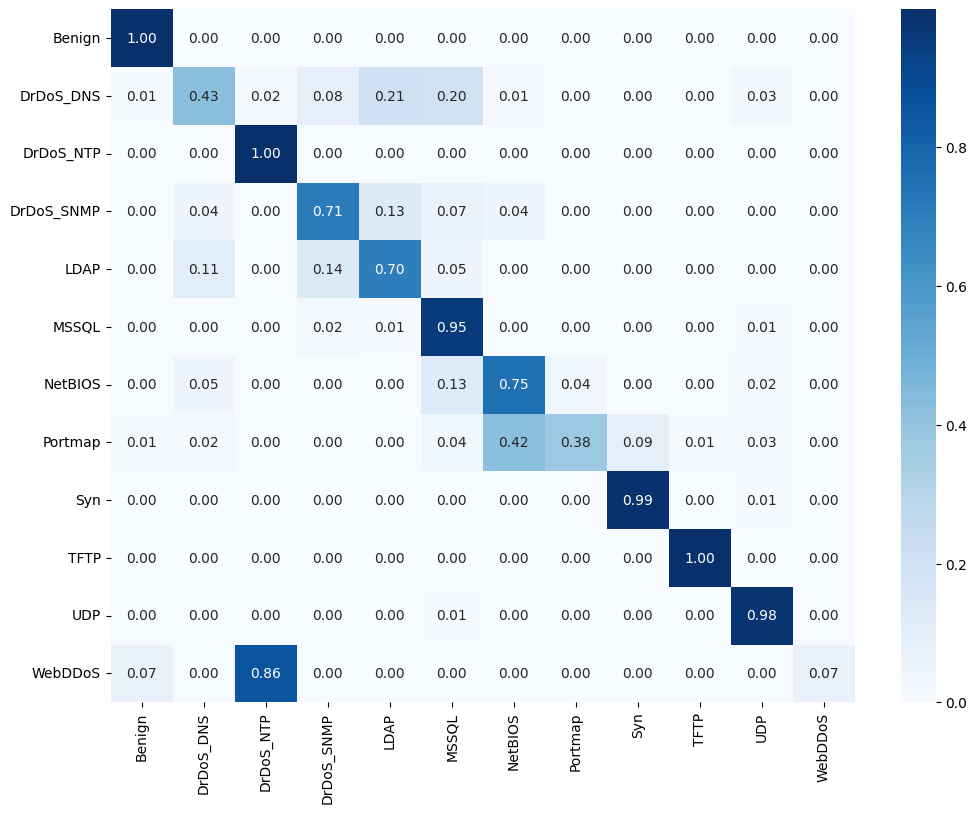

In [ ]:
plt.figure(figsize=(12,9))
cm=confusion_matrix(y_test, y_model)
cm_normalized= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized,annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_,yticklabels=le.classes_)

# Comentarios Finales

* Se identifica una precisión de 98% en todas las variaciones del modelo, lo cual es muy bueno considerando que se trata de un problema de multiclasificación

* Los tipos de ataque con menor cantidad de registros presentan un peor desempeño, lo que será un factor clave para contrastar resultados con otros tipos de modelos.

* XGBoost permite una alta precisión, recall y F1-score, y servirá como base para la creación de los demás modelos.